In this notebook we want to impute the missing values in the donors dataset 

In [3]:
import pickle 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# read the pickle file for private_income 
with open("private_donors.pkl", "rb") as pklfile:
    private_donors = pickle.load(pklfile)

In [4]:
private_donors_sorted = private_donors.sort_values(by = 'OrgCode',ascending = True)

<Axes: >

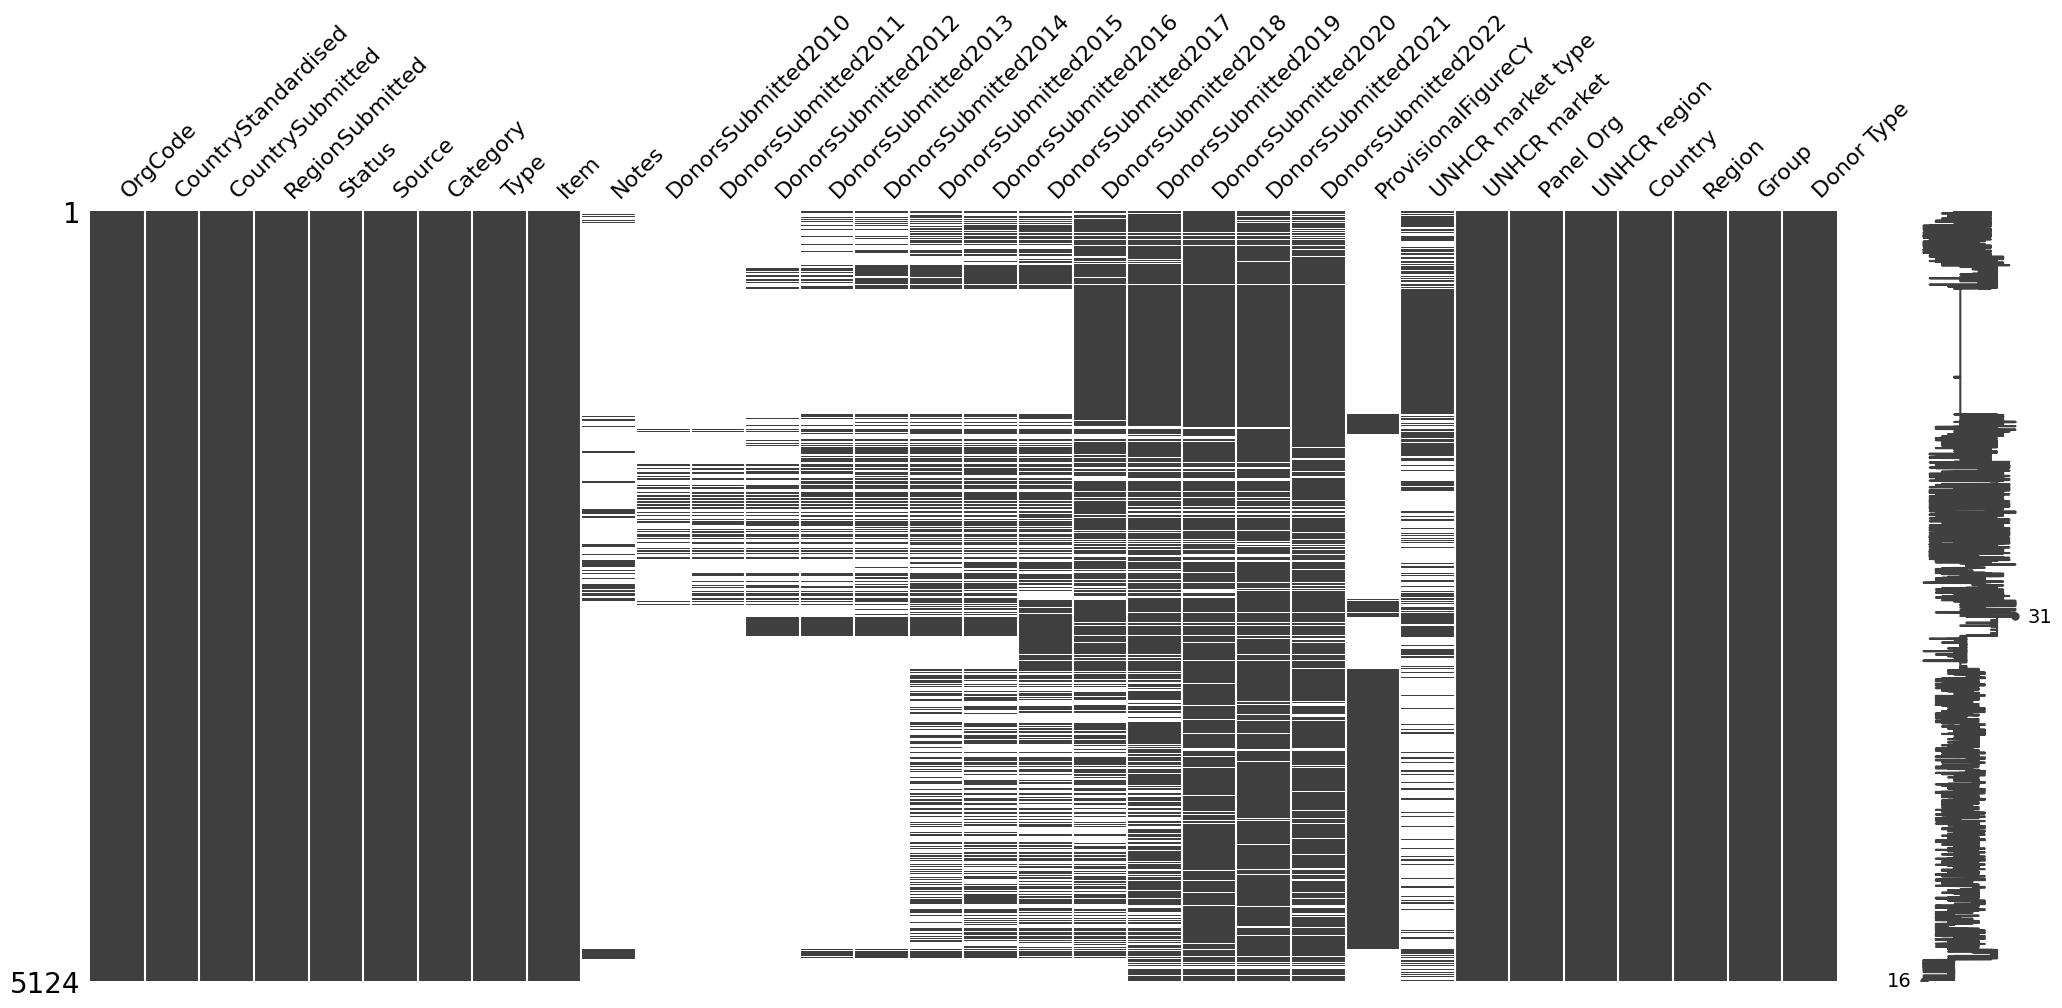

In [5]:
msno.matrix(private_donors_sorted)

<Axes: >

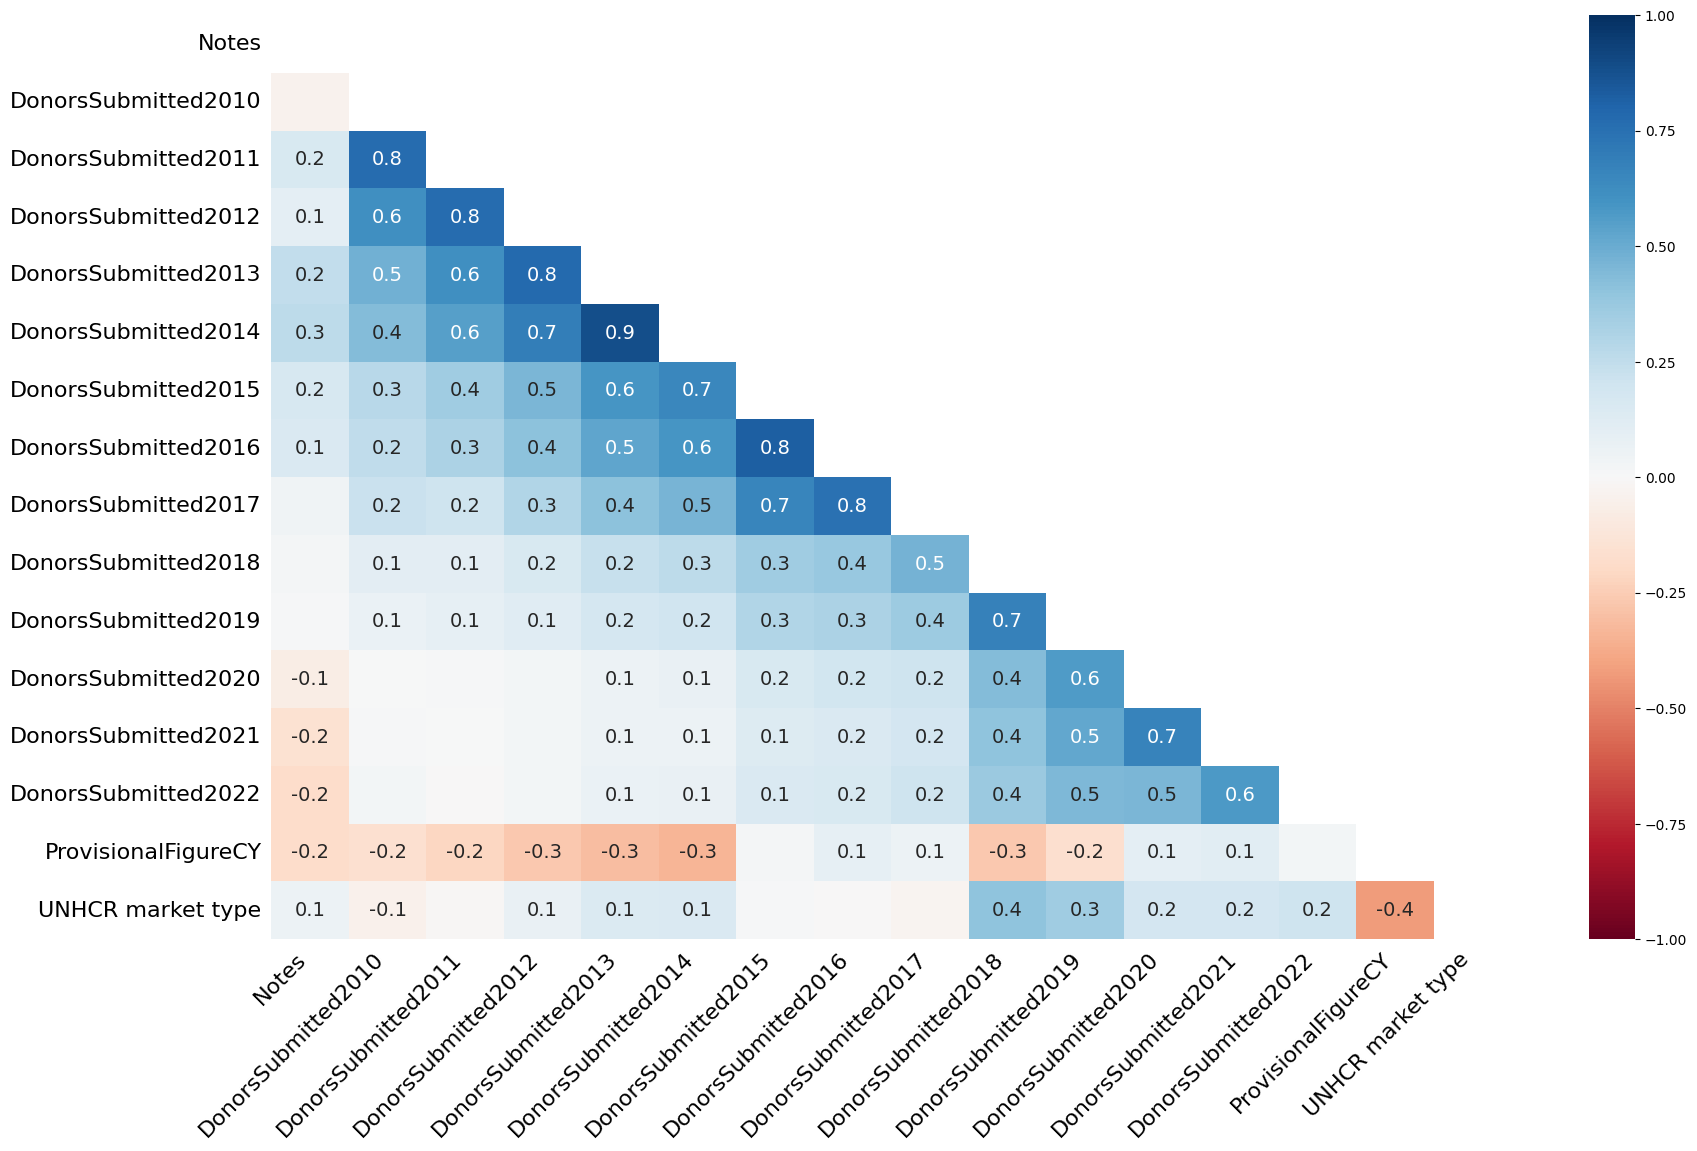

In [7]:
msno.heatmap(private_donors)

## MICE Imputation 

In [10]:
private_donors.columns

Index(['OrgCode', 'CountryStandardised', 'CountrySubmitted', 'RegionSubmitted',
       'Status', 'Source', 'Category', 'Type', 'Item', 'Notes',
       'DonorsSubmitted2010', 'DonorsSubmitted2011', 'DonorsSubmitted2012',
       'DonorsSubmitted2013', 'DonorsSubmitted2014', 'DonorsSubmitted2015',
       'DonorsSubmitted2016', 'DonorsSubmitted2017', 'DonorsSubmitted2018',
       'DonorsSubmitted2019', 'DonorsSubmitted2020', 'DonorsSubmitted2021',
       'DonorsSubmitted2022', 'ProvisionalFigureCY', 'UNHCR market type',
       'UNHCR market', 'Panel Org', 'UNHCR region', 'Country', 'Region',
       'Group', 'Donor Type'],
      dtype='object')

In [11]:
numeric_cols = ['DonorsSubmitted2010', 'DonorsSubmitted2011', 'DonorsSubmitted2012',
       'DonorsSubmitted2013', 'DonorsSubmitted2014', 'DonorsSubmitted2015',
       'DonorsSubmitted2016', 'DonorsSubmitted2017', 'DonorsSubmitted2018',
       'DonorsSubmitted2019', 'DonorsSubmitted2020', 'DonorsSubmitted2021',
       'DonorsSubmitted2022']

In [12]:
id_vars =  [col for col in private_donors.columns if col not in numeric_cols]

In [16]:
#drop duplicates
private_donors.drop_duplicates(keep = 'first',inplace = True,ignore_index = True)

In [18]:
private_donors.drop_duplicates(subset = id_vars,keep = 'last',inplace = True,ignore_index = True)

In [20]:
data_impute_reshape = pd.melt(private_donors, id_vars = id_vars , var_name = 'Date' ,value_vars=numeric_cols ,value_name = 'Donors' )
data_impute_reshape['Date'] = data_impute_reshape['Date'].str.extract(r'(\d+)') 
data_impute_reshape.head()

,OrgCode,CountryStandardised,CountrySubmitted,RegionSubmitted,Status,Source,Category,Type,Item,Notes,...,UNHCR market type,UNHCR market,Panel Org,UNHCR region,Country,Region,Group,Donor Type,Date,Donors
0,ACT,Australia,Australia,Oceania,Total,Cash,Individual Giving,Regular Giving,Sponsorships - Child,NaN,...,NAP,1,0,APAC,Australia,Asia & Pacific,Private Sector,Committed Giving,2010,NaN
1,ACT,Australia,Australia,Oceania,Newly Acquired,Cash,Individual Giving,Regular Giving,Sponsorships - Child,NaN,...,NAP,1,0,APAC,Australia,Asia & Pacific,Private Sector,Committed Giving,2010,NaN
2,ACT,Australia,Australia,Oceania,Total,Cash,Individual Giving,Regular Giving,Non-Sponsorships,NaN,...,NAP,1,0,APAC,Australia,Asia & Pacific,Private Sector,Committed Giving,2010,NaN
3,ACT,Australia,Australia,Oceania,Newly Acquired,Cash,Individual Giving,Regular Giving,Non-Sponsorships,NaN,...,NAP,1,0,APAC,Australia,Asia & Pacific,Private Sector,Committed Giving,2010,NaN
4,ACT,Australia,Australia,Oceania,Total,Cash,Individual Giving,Single Giving,Non-Sponsorships,No data for 2013-2017,...,NAP,1,0,APAC,Australia,Asia & Pacific,Private Sector,One-off Giving,2010,NaN


In [8]:
# Function to create a dictionary mapping categories to numeric values
def create_category_mapping(column):
    unique_categories = column.unique()
    category_mapping = {category: index+1 for index, category in enumerate(unique_categories)}
    return category_mapping

In [21]:
# Create a dictionary mapping categories to numeric values
category_mapping_org = create_category_mapping(data_impute_reshape['OrgCode']) 
category_mapping_source = create_category_mapping(data_impute_reshape['Source']) 
category_mapping_category = create_category_mapping(data_impute_reshape['Category']) 
category_mapping_type = create_category_mapping(data_impute_reshape['Type']) 
category_mapping_item = create_category_mapping(data_impute_reshape['Item']) 

In [22]:
#we map the modifications to the original dataset 
data_impute_reshape['numeric_OrgCode'] = data_impute_reshape['OrgCode'].map(category_mapping_org) 
data_impute_reshape['numeric_source'] = data_impute_reshape['Source'].map(category_mapping_source)
data_impute_reshape['numeric_category'] = data_impute_reshape['Category'].map(category_mapping_category)
data_impute_reshape['numeric_type'] = data_impute_reshape['Type'].map(category_mapping_type)
data_impute_reshape['numeric_item'] = data_impute_reshape['Item'].map(category_mapping_item)

In [23]:
import miceforest as mf

In [28]:
#convert date to integer 
data_impute_reshape['Date'] = data_impute_reshape['Date'].astype('int')
data_impute_reshape['Donors'] = data_impute_reshape['Donors'].astype('float')

In [29]:
selected_columns = ['numeric_OrgCode', 'numeric_source','numeric_category', 'numeric_type','numeric_item','Date','Donors']

kds = mf.ImputationKernel(
  data_impute_reshape[selected_columns],
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 2 iterations
kds.mice(2)

# Return the completed dataset.
data_complete = kds.complete_data()
data_complete

,numeric_OrgCode,numeric_source,numeric_category,numeric_type,numeric_item,Date,Donors
0,1,1,1,1,1,2010,4051.0
1,1,1,1,1,1,2010,4051.0
2,1,1,1,1,2,2010,65782.0
3,1,1,1,1,2,2010,5371.0
4,1,1,1,2,2,2010,19490.0
...,...,...,...,...,...,...,...
64761,15,1,1,1,4,2022,90.0
64762,15,1,1,1,4,2022,27158.0
64763,15,1,1,1,4,2022,2796.0
64764,15,1,1,1,4,2022,95.0


In [30]:
# we want to add the obtained dataset to the the original one through index and the value in the column 
for index,row in data_impute_reshape.iterrows():  
    if pd.isna(row['Donors']): 
        # Retrieve corresponding value from the imputed dataset using ID
        imputed_value = data_complete.loc[index, 'Donors']
        # Insert imputed value into the original dataset
        data_impute_reshape.at[index, 'Donors'] = imputed_value

In [33]:
# we will modify the date in Date 
# Define the chain value
chain_value = 'DonorsSubmitted'

# Convert each value in the 'Date' column to string and add the chain value
data_impute_reshape['Date'] = data_impute_reshape['Date'].apply(lambda x: f"{chain_value}{str(x)}")

# we will pivot the dataset into its origin having years as columns 
private_donors_full = data_impute_reshape.pivot(index = id_vars ,columns = 'Date' , values = 'Donors').reset_index() 
# we will modify the Date column to contain IncomeUSD 
private_donors_full

Date,OrgCode,CountryStandardised,CountrySubmitted,RegionSubmitted,Status,Source,Category,Type,Item,Notes,...,DonorsSubmitted2013,DonorsSubmitted2014,DonorsSubmitted2015,DonorsSubmitted2016,DonorsSubmitted2017,DonorsSubmitted2018,DonorsSubmitted2019,DonorsSubmitted2020,DonorsSubmitted2021,DonorsSubmitted2022
0,ACT,Australia,Australia,Oceania,Newly Acquired,Cash,Individual Giving,Regular Giving,Non-Sponsorships,NaN,...,160.0,1665.0,2331.0,1393.0,154.0,268.0,295.0,232.0,118.0,75.0
1,ACT,Australia,Australia,Oceania,Newly Acquired,Cash,Individual Giving,Regular Giving,Sponsorships - Child,NaN,...,5502.0,57.0,7.0,2854.0,1.0,53.0,209.0,0.0,0.0,0.0
2,ACT,Australia,Australia,Oceania,Newly Acquired,Cash,Individual Giving,Single Giving,Non-Sponsorships,NaN,...,2341.0,651.0,20.0,7710.0,2341.0,1051.0,1302.0,2332.0,2162.0,1394.0
3,ACT,Australia,Australia,Oceania,Total,Cash,Individual Giving,Regular Giving,Non-Sponsorships,NaN,...,3916.0,3819.0,3936.0,3187.0,2621.0,2221.0,1651.0,1791.0,1608.0,1837.0
4,ACT,Australia,Australia,Oceania,Total,Cash,Individual Giving,Regular Giving,Sponsorships - Child,NaN,...,850.0,648.0,576.0,559.0,429.0,345.0,292.0,219.0,194.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4977,WWF,Vietnam,Vietnam,Asia,Total,Cash,Individual Giving,Regular Giving,Memberships,NaN,...,143563.0,143563.0,109098.0,4978.0,0.0,55231.0,12.0,0.0,1.0,0.0
4978,WWF,Zambia,Zambia,Africa,Newly Acquired,Cash,Individual Giving,Regular Giving,Memberships,NaN,...,143563.0,143563.0,1.0,6411.0,37875.0,16854.0,12915.0,0.0,2516.0,11105.0
4979,WWF,Zambia,Zambia,Africa,Total,Cash,Individual Giving,Regular Giving,Memberships,NaN,...,143563.0,46729.0,0.0,6411.0,101303.0,22896.0,1.0,0.0,0.0,0.0
4980,WWF,Zimbabwe,Zimbabwe,Africa,Newly Acquired,Cash,Individual Giving,Regular Giving,Memberships,NaN,...,143563.0,519827.0,0.0,159779.0,365.0,5050.0,70903.0,186.0,2516.0,90.0


In [34]:
original_data_1 = private_donors[numeric_cols]

In [56]:
#save to excel 
original_data_1.to_excel('original_data_1.xlsx')

In [36]:
imputed_data_numerical = private_donors_full[numeric_cols]

In [37]:
# what we want to do is to modify the original dataset with the condition we set 
def meets_condition(row):
    non_missing_encountered = False
    indices = []
    for i, value in enumerate(row):
        if not pd.isnull(value):
            non_missing_encountered = True
        elif pd.isnull(value) and non_missing_encountered:
            indices.append(i)
    return indices
number_rows = 0
# Transfer imputed values back to the original DataFrame based on the condition
for index, row in original_data_1.iterrows():
    non_missing_columns = meets_condition(row)
    for col_index in non_missing_columns:
        col_name = original_data_1.columns[col_index]
        original_data_1.loc[index, col_name] = imputed_data_numerical.loc[index, col_name]
        number_rows = number_rows + 1 
# Display the updated data
print("Updated DataFrame:")
original_data_1.head() 

C:\Users\nourd\AppData\Local\Temp\ipykernel_25476\2687006462.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_data_1.loc[index, col_name] = imputed_data_numerical.loc[index, col_name]


Updated DataFrame:


,DonorsSubmitted2010,DonorsSubmitted2011,DonorsSubmitted2012,DonorsSubmitted2013,DonorsSubmitted2014,DonorsSubmitted2015,DonorsSubmitted2016,DonorsSubmitted2017,DonorsSubmitted2018,DonorsSubmitted2019,DonorsSubmitted2020,DonorsSubmitted2021,DonorsSubmitted2022
0,NaN,NaN,NaN,850.0,648.0,576.0,559.0,429.0,345.0,292.0,219.0,194.0,0.0
1,NaN,NaN,NaN,NaN,57.0,7.0,2854.0,1.0,53.0,209.0,0.0,0.0,0.0
2,NaN,NaN,NaN,3916.0,3819.0,3936.0,3187.0,2621.0,2221.0,1651.0,1791.0,1608.0,1837.0
3,NaN,NaN,NaN,NaN,1665.0,2331.0,1393.0,154.0,268.0,295.0,232.0,118.0,75.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6129.0,5135.0,5918.0,194.0,4311.0


In [38]:
private_donors.columns

Index(['OrgCode', 'CountryStandardised', 'CountrySubmitted', 'RegionSubmitted',
       'Status', 'Source', 'Category', 'Type', 'Item', 'Notes',
       'DonorsSubmitted2010', 'DonorsSubmitted2011', 'DonorsSubmitted2012',
       'DonorsSubmitted2013', 'DonorsSubmitted2014', 'DonorsSubmitted2015',
       'DonorsSubmitted2016', 'DonorsSubmitted2017', 'DonorsSubmitted2018',
       'DonorsSubmitted2019', 'DonorsSubmitted2020', 'DonorsSubmitted2021',
       'DonorsSubmitted2022', 'ProvisionalFigureCY', 'UNHCR market type',
       'UNHCR market', 'Panel Org', 'UNHCR region', 'Country', 'Region',
       'Group', 'Donor Type'],
      dtype='object')

In [39]:
private_donors_new = private_donors

In [40]:
# Set the years range
years_range = range(2010, 2023)


# Transfer the columns from df1 to df2 for each year in the range
for year in years_range:
    column_name = f"DonorsSubmitted{year}"
    if column_name in original_data_1.columns:
        private_donors_new[column_name] = original_data_1[column_name]

In [45]:
private_donors[numeric_cols].equals(original_data_1)

True

In [41]:
#save the new variable dataset 
%store private_donors_new

Stored 'private_donors_new' (DataFrame)
